In [22]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [6]:
df.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Plot the label distribution

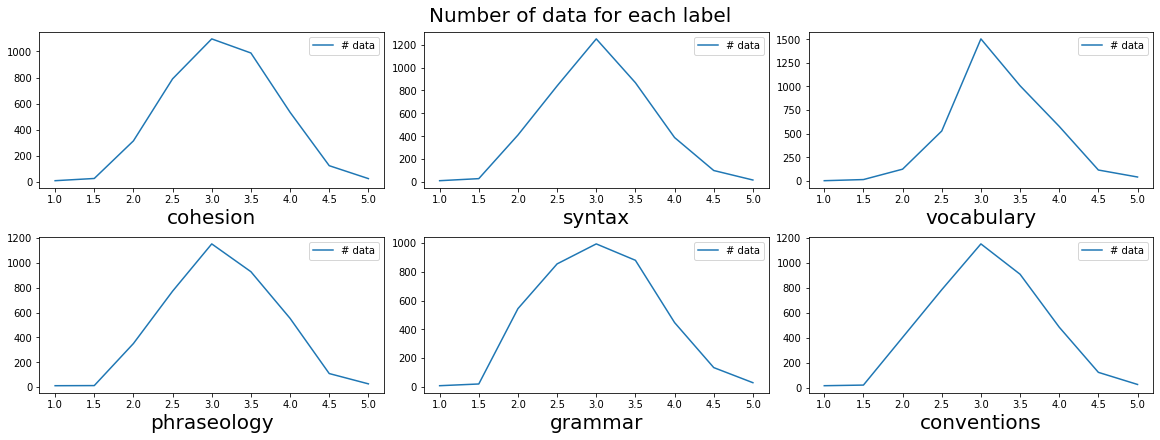

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (16,6), constrained_layout=True)
fig.suptitle("Number of data for each label", size = 20)
#fig.figsize(16,6)
for i in range(2):
    for j in range(3):
        df.groupby(target_cols[i*3+j])[target_cols[i*3+j]].count().plot(ax = axes[i,j])
        axes[i,j].set_xlabel(target_cols[i*3+j], fontsize=20)
        axes[i,j].legend(['# data'])

The above figures show that there are less data of 1.0, 1.5, 4.5, and 5.0 for each essay evaluation criterion. Therefore, I use stratified kfold to split train and valid dataset.

## Plot the correlation between the labels

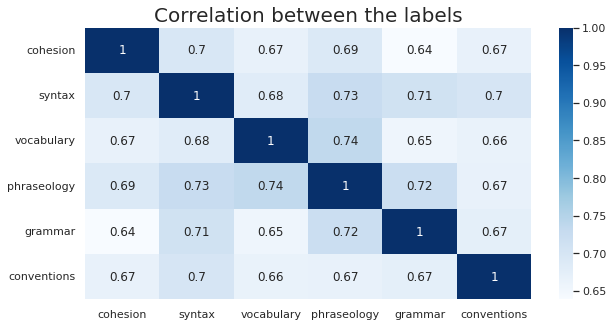

In [14]:
corr = df[target_cols].corr()
sns.set(rc = {"figure.figsize": (10, 5)})
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap="Blues", annot = True).set_title("Correlation between the labels", fontsize = 20)
plt.show()

The correlation between the labels are generally high. Especially, correlation between vocabulary and phraseology is highest. This leads to using one backbone to predict the score of multilabels, because training separate model for each label is likely to loss correlated information between the labels.

## Word Count

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max length: 1260, avg length: 430


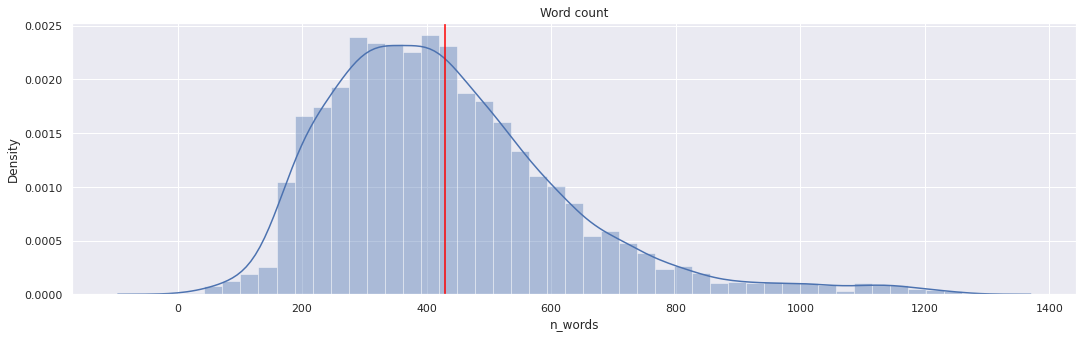

In [20]:
df['n_words'] = df['full_text'].apply(lambda x: len(x.split()))
avg_words = round(df['n_words'].mean())
max_words = round(df['n_words'].max())

plt.figure(figsize = (18, 5))
sns.distplot(df['n_words'])
plt.axvline(x = avg_words, color = 'red')
plt.title('Word count')

print(f"max length: {max_words}, avg length: {avg_words}")

The figure above shows that the avergae number of words in a text is 430, and there are few examples whose length is more than 1000.

## Baseline Prediction Analysis

The following code is the analysis of the baseline prediction. This is to check what example is inconsistent with baseline prediction, and whether the baseline's prediction is biased to one side. Through this, it is possible to determine which part of the model will improve its performance.

cohesion length 10
syntax length 11
vocabulary length 2
phraseology length 10
grammar length 8
conventions length 15


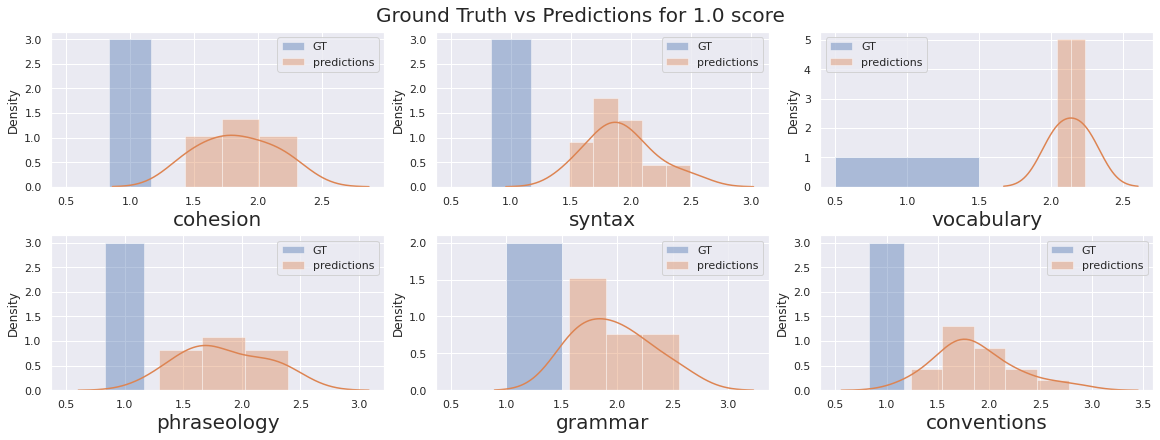

In [23]:
train_oof = pd.read_pickle('../input/layerwise2/oof_df.pkl')

fig, axes = plt.subplots(2, 3, figsize = (16,6), constrained_layout=True)
fig.suptitle("Ground Truth vs Predictions for 1.0 score", size = 20)
#fig.figsize(16,6)
for i in range(2):
    for j in range(3):
        
        train_oof_one = train_oof[train_oof[target_cols[i*3+j]] == 1.0]
        sns.distplot(train_oof_one[target_cols[i*3+j]], ax = axes[i,j], label = "GT")
        sns.distplot(train_oof_one['pred_' + target_cols[i*3+j]], ax = axes[i,j], label = "Predictions")
        axes[i,j].legend(["GT", "predictions"])
        axes[i,j].set_xlabel(target_cols[i*3+j], fontsize=20)
        #axes[i,j].label("Predictions")
                     
        print(f"{target_cols[i*3+j]} length", len(train_oof_one))
        #axes[i,j].set_title(target_cols[i*3+j])

cohesion length 26
syntax length 17
vocabulary length 41
phraseology length 25
grammar length 29
conventions length 25


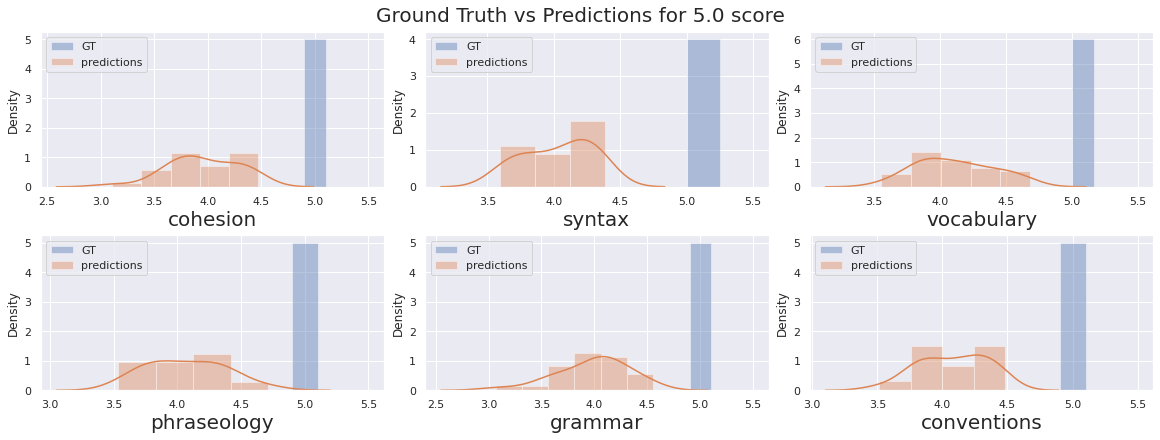

In [26]:
fig, axes = plt.subplots(2, 3, figsize = (16,6), constrained_layout=True)
fig.suptitle("Ground Truth vs Predictions for 5.0 score", size = 20)
#fig.figsize(16,6)
for i in range(2):
    for j in range(3):
        
        train_oof_one = train_oof[train_oof[target_cols[i*3+j]] == 5.0]
        sns.distplot(train_oof_one[target_cols[i*3+j]], ax = axes[i,j], label ='GT')
        sns.distplot(train_oof_one['pred_' + target_cols[i*3+j]], ax = axes[i,j], label ='predictions')
        axes[i,j].legend(["GT", "predictions"])
        axes[i,j].set_xlabel(target_cols[i*3+j], fontsize=20)
        
        print(f"{target_cols[i*3+j]} length", len(train_oof_one))
        #axes[i,j].set_title(target_cols[i*3+j])

The two figures above show that the baseline prediction is biased to 3.0. This result may have been obtained because 3.0 and 3.5 examples are relatively larger than other examples. Therefore, I will try data augmentation for 1.0, 1.5, 4.5, and 5.0 example, or other methods to resolve the biased predictions.